In [1]:
from utils import *
%load_ext autoreload
%autoreload 2

In [2]:
X_train, y_train, X_test = read_train_test(sentence_per_row_mode=True)

Reading training data ...
Reading training data : Done
Reading testing data ...
Reading testing data : Done


In [3]:
X_train["text_joined"] = [" ".join(X_train.text[i]) for i in range(X_train.shape[0])]

In [214]:
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer

stop_words = set(stopwords.words('french'))
stemmer = FrenchStemmer()

def process_text(text, stem=False):
    """ lowercase, removes stopwords, lemmatizes"""
    text = unidecode.unidecode(text.replace("’", " ").lower())
    tokens = text.split()
    if stem :
        tokens_no_stpwrd = [stemmer.stem(tok) for tok in tokens if tok not in stop_words]
    else :
        tokens_no_stpwrd = [tok for tok in tokens if tok not in stop_words]

    return " ".join(tokens_no_stpwrd)

X_train["text_processed"] = X_train.text_joined.apply(process_text, args=(False,))

In [4]:
# y_train.loc[X_train[X_train.filename == "Bordeaux_605561.txt"].index]

In [3]:
sex_prediction = X_train.text.apply(naive_sex_classifier, args=(0.85, 1))

In [11]:
print("Nombre de fois où on se trompe de sexe : {}".format((sex_prediction != y_train.sexe).sum()))
print("Dont : {} femmes".format((y_train[(sex_prediction != y_train.sexe)].sexe == "femme").sum()))

Nombre de fois où on se trompe de sexe : 90
Dont : 61 femmes


***

# Extraction du contexte autour de la date (utilisant la target )

In [186]:
import unidecode

In [188]:
unidecode.unidecode("février")

'fevrier'

In [217]:
def date_parser(date_string):
    """ Transforme une date de YYYY-mm-DD 
        en DD mm (en lettre) YYYY """
    
    year_month_day = date_string.split('-')
    
    list_Months=['Janvier',"Février",
                 'Mars','Avril','Mai','Juin','Juillet',
                 "Août",'Septembre','Octobre','Novembre',
                 "Décembre"]
    list_months=['janvier',"février",
                 'mars','avril','mai','juin','juillet',
                 "août",'septembre','octobre','novembre',
                 "décembre"]
    
    day = str(int(year_month_day[2])) # sans le 0 qui précède les unités
    Month = list_Months[int(year_month_day[1])-1]
    month = list_months[int(year_month_day[1])-1]
    year = year_month_day[0]
    
    if day == "1":
        day +="er"
    return day + " " + Month + " " + year, day + " " + month + " " + year

In [218]:
def extract_X_sentences_before_after(text, date, X=2):
    
    try :
        capitalized_date, non_capitalized_date = date_parser(date)
    except :
        return "Date NC"
    
    L1 = [capitalized_date in sen for sen in text]
    L2 = [non_capitalized_date in sen for sen in text]
    
    if np.array(L1).any() :
        index = np.where(L1)[0][0]
        CAP=True
    elif np.array(L2).any() :
        index = np.where(L2)[0][0]
        CAP=False
    else :
        return "Pas trouvé de Date sous format DD mm (en lettre) YYYY dans le texte"
    
    
    result = text[index-X : index+X+1]
    if CAP:
        result = [e.replace(capitalized_date, "") for e in result]
    else :
        result = [e.replace(non_capitalized_date, "") for e in result]
    return result

import itertools
import igraph
import copy

def terms_to_graph(terms, window_size):
    '''This function returns a directed, weighted igraph from lists of list of terms (the tokens from the pre-processed text)
    e.g., ['quick','brown','fox']
    Edges are weighted based on term co-occurence within a sliding window of fixed size 'w'
    '''
    
    from_to = {}

    w = min(window_size, len(terms))
    # create initial complete graph (first w terms)
    terms_temp = terms[0:w]
    indexes = list(itertools.combinations(range(w), r=2))

    new_edges = []

    for my_tuple in indexes:
        new_edges.append(tuple([terms_temp[i] for i in my_tuple]))
    for new_edge in new_edges:
        if new_edge in from_to:
            from_to[new_edge] += 1
        else:
            from_to[new_edge] = 1

    # then iterate over the remaining terms
    for i in range(w, len(terms)):
        # term to consider
        considered_term = terms[i]
        # all terms within sliding window
        terms_temp = terms[(i - w + 1):(i + 1)]

        # edges to try
        candidate_edges = []
        for p in range(w - 1):
            candidate_edges.append((terms_temp[p], considered_term))

        for try_edge in candidate_edges:

            # if not self-edge
            if try_edge[1] != try_edge[0]:

                # if edge has already been seen, update its weight
                if try_edge in from_to:
                    from_to[try_edge] += 1

                # if edge has never been seen, create it and assign it a unit weight
                else:
                    from_to[try_edge] = 1

    # create empty graph
    g = igraph.Graph(directed=True)

    # add vertices
    g.add_vertices(sorted(set(terms)))

    # add edges, direction is preserved since the graph is directed
    g.add_edges(list(from_to.keys()))

    # set edge and vertice weights
    g.es['weight'] = list(from_to.values()) # based on co-occurence within sliding window
    g.vs['weight'] = g.strength(weights=list(from_to.values())) # weighted degree

    return (g)

def core_dec(g,weighted):
    '''(un)weighted k-core decomposition'''
    # work on clone of g to preserve g 
    gg = copy.deepcopy(g)
    if not weighted:
        gg.vs['weight'] = gg.strength() # overwrite the 'weight' vertex attribute with the unweighted degrees
    # initialize dictionary that will contain the core numbers
    cores_g = dict(zip(gg.vs['name'],[0]*len(gg.vs)))
    
    while len(gg.vs) > 0:
        # find index of lowest degree vertex
        min_degree = min(gg.vs['weight'])
        index_top = gg.vs['weight'].index(min_degree)
        name_top = gg.vs[index_top]['name']
        # get names of its neighbors
        neighbors = gg.vs[gg.neighbors(index_top)]['name']
        # exclude self-edges
        neighbors = [elt for elt in neighbors if elt!=name_top]
        # set core number of lowest degree vertex as its degree
        cores_g[name_top] = min_degree
        # delete top vertex and its incident edges
        gg.delete_vertices(index_top)
        
        if neighbors:
            if weighted: 
                new_degrees = gg.strength(weights=gg.es['weight'])
            else:
                new_degrees = gg.strength()
            # iterate over neighbors of top element
            for neigh in neighbors:
                index_n = gg.vs['name'].index(neigh)
                gg.vs[index_n]['weight'] = max(min_degree,new_degrees[index_n])  
        
    return(cores_g)


In [219]:
context_to_analyse = extract_X_sentences_before_after(X_train.text[0], y_train.date_accident[0], X=1)
# context_to_analyse = [sen for sen in context_to_analyse if sen]
words = process_text(" ".join(context_to_analyse))
words

', monsieur x... a ete victime accident travail cours duquel a ete gravement blesse.'

In [9]:
# g = terms_to_graph(words.split(" "), 4)
# dico = core_dec(g, True)
# dico

# Contexte autour de la date d':

## Accident

In [254]:
L = []
for i in range(X_train.shape[0]) :
    context_to_analyse = extract_X_sentences_before_after(X_train.text[i], y_train.date_accident[i], X=4)
    if context_to_analyse in ["Pas trouvé de Date sous format DD mm (en lettre) YYYY dans le texte", "Date NC"] :
        L.append(context_to_analyse)
    else :
        words = process_text(" ".join(context_to_analyse))
        L.append(words)
X_train["context_around_accident"] = L

In [255]:
L = []
for i in range(X_train.shape[0]) :
    text = X_train.context_around_accident[i]
    if text in ["Pas trouvé de Date sous format DD mm (en lettre) YYYY dans le texte", "Date NC"] :
        L.append(None)
    else :
        words = " ".join([tok for tok in text.split() if tok.isalnum()])
        L.append(words)
X_train["context_around_accident_processed"] = L

## Consolidation

In [256]:
L = []
for i in range(X_train.shape[0]) :
    context_to_analyse = extract_X_sentences_before_after(X_train.text[i], y_train.date_consolidation[i], X=4)
    if context_to_analyse in ["Pas trouvé de Date sous format DD mm (en lettre) YYYY dans le texte", "Date NC"] :
        L.append(context_to_analyse)
    else :
        words = process_text(" ".join(context_to_analyse))
        L.append(words)
X_train["context_around_consolidation"] = L

In [257]:
L = []
for i in range(X_train.shape[0]) :
    text = X_train.context_around_consolidation[i]
    if text in ["Pas trouvé de Date sous format DD mm (en lettre) YYYY dans le texte", "Date NC"] :
        L.append(None)
    else :
        words = " ".join([tok for tok in text.split() if tok.isalnum()])
        L.append(words)
X_train["context_around_consolidation_processed"] = L

## Spacy word vectors

In [74]:
import fr_core_news_md
nlp = fr_core_news_md.load()

In [258]:
def extract_X_sentences_around_all_dates(text, X=1):
    """The text in structured format ( like in the column text of X_train)
    - Looks for all the dates in the text
    - for each date, extract X sentences  before and after this date (sentence meaning rows of the original doc)
    - if a row has multiple dates, separate each date in a row (the dates will have the same context) ==> PROBLEM
    - Return a list of tuples (context in lower + no stopwords + clean from punct , date)
    - this context can be passed to Spacy avg vectorizer to get the avg Word embedding of the sentence
    """
    l = [re.findall("\d{1,2} [a-zéû]{3,9} \d{4}", STRING.lower()) for STRING in text]
    indexes = [i for i in range(len(l)) if len(l[i])!=0]
    ll = [(" ".join(text[i-X+1 : i+X]).lower(), l[i]) for i in indexes]
    
    lll = []
    for i in range(len(ll)) :
        if len(ll[i][1]) == 1 :
            date = unidecode.unidecode(ll[i][1][0])
            context_date_removed = unidecode.unidecode(ll[i][0]).replace(date, '')
            context_date_removed_processed = " ".join([tok for tok in context_date_removed.split() if (tok.isalnum()) & (tok not in stop_words) ])
            lll.append((context_date_removed_processed, date))
        else :
            for j in range(len(ll[i][1])) :
                date = unidecode.unidecode(ll[i][1][j])
                context_date_removed = unidecode.unidecode(ll[i][0]).replace(date, '')
                context_date_removed_processed = " ".join([tok for tok in context_date_removed.split() if (tok.isalnum()) & (tok not in stop_words) ])
                lll.append((context_date_removed_processed, date))
    return lll

In [259]:
def letter_date_to_submission_date(string) :
    dico_months = {"janvier" : "01",
               'fevrier' : "02",
               "mars" : "03",
               "avril" : "04",
               "mai" : "05",
               "juin" : "06",
               "juillet" : "07",
               "aout" : "08",
                "septembre" : "09",
               "octobre": '10',
               "novembre" : "11",
               "decembre":'12'}
    strings = string.split()
    
    if len(strings[0]) == 1 :
        day = "0"+strings[0]
    else :
        day = strings[0]
    return strings[2]+"-"+dico_months[strings[1]]+"-"+day

To asses the performance of our model that predicts if the context around a date is talking about `date d'accident` or `date de consolidation` :

- Take split X_train using train_test_split into X_tr and X_te
- Prepare data for model fitting :
    - For date d'accident : 
        - remove the dates from the accident contexts of X_tr
        - remove the punctuation from the accident contexts of X_tr
        - remove the stopwords from the accident contexts of X_tr  
        - use Spacy avg vectorizer 
    - Same thing for date de conso
    - concatenate the two 
    - fit two models : one to predict accident contexts and the other the consolidation contexts
- On X_te :
    - On each text apply the function extract `X_sentences_around_all_dates`
    - for each sentence apply the Spacy vectorizer and predict using the models
    - predict the date of which the context gave the higher probability score.

In [260]:
X_tr, X_te = train_test_split(X_train, random_state=50)

<IPython.core.display.Javascript object>

In [261]:
train_accident_context_avg_WV = np.array([
    nlp(sen).vector for sen in X_tr.context_around_accident_processed if sen is not None ])

train_consolidation_context_avg_WV = np.array([
    nlp(sen).vector for sen in X_tr.context_around_consolidation_processed if sen is not None ])

from sklearn.linear_model import LogisticRegression


is_accident = [1 for _ in range(train_accident_context_avg_WV.shape[0])]
is_not_accident = [0 for _ in range(train_consolidation_context_avg_WV.shape[0])]
data = np.concatenate((train_accident_context_avg_WV, train_consolidation_context_avg_WV))
target = np.concatenate((is_accident, is_not_accident))
clf_accident = LogisticRegression().fit(data, target)

###############################################

is_conso = [1 for _ in range(train_consolidation_context_avg_WV.shape[0])]
is_not_conso = [0 for _ in range(train_accident_context_avg_WV.shape[0])]
data = np.concatenate((train_consolidation_context_avg_WV, train_accident_context_avg_WV))
target = np.concatenate((is_conso, is_not_conso))
clf_conso = LogisticRegression().fit(data, target)


C:\Users\Houcine's laptop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Houcine's laptop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [276]:
y_true_accident = y_train.loc[X_te.index].date_accident.values
y_true_consolidation = y_train.loc[X_te.index].date_consolidation.values

y_pred_accident = []
y_pred_conso = []
for i in range(X_te.text.shape[0]) :
    
    sentences_to_test = extract_X_sentences_around_all_dates(X_te.text.iloc[i])
    probas_accident = []
    probas_conso = []

    for tup in sentences_to_test :

        processed_sentence = tup[0]
        WV_processed_sentence = nlp(processed_sentence).vector

        probas_accident.append(clf_accident.predict_proba([WV_processed_sentence]))
        probas_conso.append(clf_conso.predict_proba([WV_processed_sentence]))
    
    probas_accident = np.squeeze(probas_accident)[:,1]
    probas_conso = np.squeeze(probas_conso)[:,1]
    
    threshold_accident = 0.7
    threshold_conso = 0.7
    
    if probas_accident.max() >= threshold_accident :
        y_pred_accident.append(letter_date_to_submission_date(sentences_to_test[np.argmax(probas_accident)][1]))
    else :
        y_pred_accident.append("n.c.")
        
    if probas_accident.max() >= threshold_conso :
        y_pred_conso.append(letter_date_to_submission_date(sentences_to_test[np.argmax(probas_conso)][1]))
    else :
        y_pred_conso.append("n.c.")
    

In [277]:
(y_true_accident == y_pred_accident).mean()

0.16062176165803108

In [278]:
(y_true_consolidation == y_pred_conso).mean()

0.27461139896373055

In [282]:
i = 18
sentences_to_test = extract_X_sentences_around_all_dates(X_te.text.iloc[i])
probas_accident = []
probas_conso = []

for tup in sentences_to_test :

    processed_sentence = tup[0]
    WV_processed_sentence = nlp(processed_sentence).vector

    probas_accident.append(clf_accident.predict_proba([WV_processed_sentence]))
    probas_conso.append(clf_conso.predict_proba([WV_processed_sentence]))

probas_accident = np.squeeze(probas_accident)[:,1]
probas_conso = np.squeeze(probas_conso)[:,1]
letter_date_to_submission_date(sentences_to_test[np.argmax(probas_accident)][1])

'2012-09-13'

In [283]:
sentences_to_test[np.argmax(probas_accident)], probas_accident.max(),y_true_accident[i]

(('conclusions datees fernand sollicite confirmation jugement sauf demande a cour',
  '13 septembre 2012'),
 0.9921591539182403,
 '2005-03-05')

In [289]:
sentences_to_test[np.argmax(probas_conso)], probas_conso.max(), y_true_consolidation[i]

(('date consolidation', '31 janvier 2009'), 0.9999999999990281, '2009-01-31')

In [286]:
sentences_to_test[15]

('vehicule marque hyundai immatricule a ete percute vehicule marque renault immatricule conduit louis etat alcoolique sans permis loue concubine mme ginette aupres societe ge financement pacifique plus couvert automobile obligatoire depuis 31 aout',
 '05 mars 2005')

In [287]:
probas_accident[15]

0.9622290715074315

In [75]:
accident_context_avg_WV = np.array([nlp(sen).vector for sen in X_train.context_around_accident_processed if sen is not None ])
consolidation_context_avg_WV = np.array([nlp(sen).vector for sen in X_train.context_around_consolidation_processed if sen is not None ])

In [76]:
is_accident = [1 for _ in range(accident_context_avg_WV.shape[0])]
is_not_accident = [0 for _ in range(consolidation_context_avg_WV.shape[0])]
data = np.concatenate((accident_context_avg_WV, consolidation_context_avg_WV))
target = np.concatenate((is_accident, is_not_accident))

In [206]:
data.shape, target.shape

((1143, 300), (1143,))

<IPython.core.display.Javascript object>

C:\Users\Houcine's laptop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score on the test set (on WV directly) :  0.8951048951048951


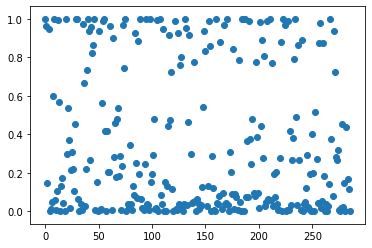

In [81]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

x_tr, x_te, y_tr, y_te = train_test_split(data, target, stratify= target)
clf_accident = LogisticRegression().fit(x_tr, y_tr)
print("Score on the test set (on WV directly) : ", clf_accident.score(x_te, y_te))
plt.scatter(range(x_te.shape[0]), clf_accident.predict_proba(x_te)[:,1]);

<IPython.core.display.Javascript object>

C:\Users\Houcine's laptop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score on the test set (on WV directly) :  0.8916083916083916


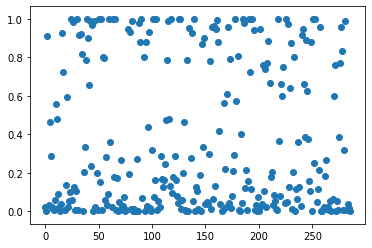

In [82]:
is_conso = [1 for _ in range(consolidation_context_avg_WV.shape[0])]
is_not_conso = [0 for _ in range(accident_context_avg_WV.shape[0])]
data = np.concatenate((consolidation_context_avg_WV, accident_context_avg_WV))
target = np.concatenate((is_conso, is_not_conso))

x_tr, x_te, y_tr, y_te = train_test_split(data, target, stratify= target)
clf_conso = LogisticRegression().fit(x_tr, y_tr)
print("Score on the test set (on WV directly) : ", clf_conso.score(x_te, y_te))
plt.scatter(range(x_te.shape[0]), clf_accident.predict_proba(x_te)[:,1]);

In [244]:
clf_accident.predict_proba([nlp(text_no_date_processed).vector])

array([[0.95305513, 0.04694487]])

In [245]:
clf_conso.predict_proba([nlp(text_no_date_processed).vector])

array([[0.99596141, 0.00403859]])

In [83]:
X_train.context_around_accident_processed

ID
0      monsieur a victime accident travail cours duqu...
1      faits procédure monsieur michaël né 1er octobr...
2      madame victime accident suite violent coup fre...
3      alors circulait volant marie france a heurtée ...
4      a subi intervention cataracte oeil gauche prat...
                             ...                        
765    voir fixer comme suit différents préjudices su...
766    considérant experts fixé période itt fin août ...
767    rappel faits procedure alain a victime collisi...
768    pascal né 19 avril handicapé 80 suite liposarc...
769    dit service société saeq international lors su...
Name: context_around_accident_processed, Length: 770, dtype: object